# Домашнее задание №7: деревья, случайный лес (14.5 баллов)

## Часть 1: основы построения решающие дерева

начнём с простого...

### Задание 1.1 (1 балл)
Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 - $k_2$. Посчитайте энтропию (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [8]:
import math
def entropy(lis):
    return sum(-p/sum(lis)*math.log(p/sum(lis), math.e) for p in lis)
print("%.2f" % entropy([8,2]))

#print(-0.8*math.log(0.8, math.e)-0.2*math.log(0.2, math.e)) # <= или так

0.50


#### (*・‿・)ノ⌒*:･ﾟ✧

### Задание 1.2 (1 балл)
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности (в формулировке разности impurity пришедшей выборки и полученного разбиения) такой вершины с применением индекса Джини. Ответ округлите до двух знаков после запятой.

In [9]:
def gini(lis):
    return sum(p/sum(lis) * (1-p/sum(lis)) for p in lis)
def impurity(lis):
    return (gini(lis) - gini([0,lis[1]])- gini([lis[0], 0]))
print("%.2f" % impurity([8, 2]))

0.32


#### (￣▽￣)/♫•*¨*•.¸¸♪

### Задание 1.3 (0.5 балла)
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [10]:
def answer(lis):
    return 1/len(lis) * sum(p for p in lis)
print("%.2f" % answer([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]))

40.60


#### ༼ つ ◕_◕ ༽つ

## Часть 2: решающие деревья

### Задание 2.1 (2 балла)
Первым делом реализуйте функцию `find_best_split`, которая должна находить оптимальное разбиение подмножества обучающей выборки. Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [51]:
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

In [52]:
boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

При решении задания имейте в виду, что под критерием Джини подразумевается такая функция:

$$Q(R) = -\frac {|R_{\ell}|}{|R|}H(R_\ell) -\frac {|R_r|}{|R|}H(R_r) ,$$

где $R$ — множество объектов, попавших в вершину, $R_{\ell}$ и $R_r$ — объекты, попавшие в левое и правое поддеревья,
$H(R) = 1 - p_1^2 - p_0^2$, $p_1$, $p_0$ — доли объектов класса 1 и 0 соответственно.

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям (скачайте решённую версию ноутбука).

In [53]:
from typing import Iterable, List, Tuple
import numpy as np
import pandas as pd
def H_class(R: pd.DataFrame)->float:
    return 1 - ((len(R) - np.count_nonzero(R))/len(R)) ** 2 - (np.count_nonzero(R)/len(R)) ** 2

In [54]:
def H_reg(R: pd.DataFrame)->float:
    return np.var(R)

In [55]:
def gini(t: float, R_m: np.ndarray, f: np.ndarray, task: str) -> float:
    R_left = R_m[f<=t]
    R_right = R_m[f>t]
    if len(R_left) == 0 or len(R_right) == 0:
        return np.NaN
    if task == "classification":
        H_L = H_class(R_left)
        H_R = H_class(R_right)
        return - (len(R_left) * H_class(R_left) + len(R_right) * H_class(R_right)) / len(R_m)
    if task == "regression":
        H_L = H_reg(R_left)
        H_R = H_reg(R_right)
        return - (len(R_left) * H_reg(R_left) + len(R_right) * H_reg(R_right)) / len(R_m)

In [56]:
def mean_f(a,b):
    return (a+b)/2
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    thresholds = []
    if feature_type == "real":
        arr = sorted(feature_vector)
        vmean_f = np.vectorize(mean_f)
        thresholds = np.unique(vmean_f(arr[:-1], arr[1:]))
    else: # feature_type == "categorial":
        thresholds = np.sort(np.unique(feature_vector))
    vgini = np.vectorize(gini, excluded=['R_m', 'f', 'task'])
    ginis = vgini(thresholds, R_m=target_vector, f=feature_vector, task=task)
    j = np.argmax(ginis)
    threshold_best = thresholds[j]
    gini_best = ginis[j]
    return thresholds, ginis, threshold_best, gini_best
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)
    arr = sorted(feature_vector)
    vmean_f = np.vectorize(mean_f)
    thresholds = np.unique(vmean_f(arr[0:-1], arr[1:]))
    
    
    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————(T_T)-


thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

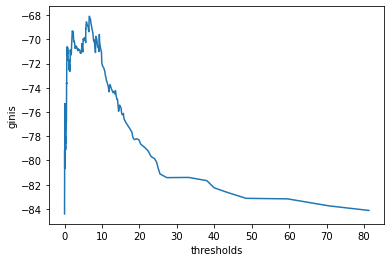

In [57]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- (×﹏×)
plt.plot(thresholds, variances)
plt.xlabel("thresholds")
plt.ylabel("ginis")
plt.show()

### Задание 2.2 (3 балла)
Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод _predict_node.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- Выбор лучшего разбиения необходимо производить по критерию Джини
- Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку
- Ответ в листе: наиболее часто встречающийся класс в листе

In [75]:
class DecisionTree:
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            print(type(feature_types[0]))
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
            
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}
        
            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            if gini_best is None or gini > gini_best:
            #if gini_best is None or ( not (gini is None) and gini > gini_best):

                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- (＋_＋)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold_best 
                    # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————- (＋_＋)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        if node["type"] =="terminal":
            return node["class"]
        else:
            if self._feature_types[node['feature_split']] == "real":
                if x[node['feature_split']] <= node["threshold"]:
                    return self._predict_node(x, node["left_child"]) #нужно передать поддерево, в которое попадет элемент х
                else:
                    _predict_node(x, node["right_child"])                 
            elif x[node['feature_split']] == "categorical":
                if x[node['feature_split']] == node["category_split"]:
                    return self._predict_node(x, node["left_child"])
                else:
                    return self._predict_node(x, node["right_child"])
                    
                    

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

### Задание 2.3 (1 балл)
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [59]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
import pandas as pd
df = pd.read_csv('students.csv')
y = df[df.columns[-1]]

In [60]:
df[:2]

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.0,0.00,0.0,0
1,0.08,0.08,0.1,0.24,0.9,1


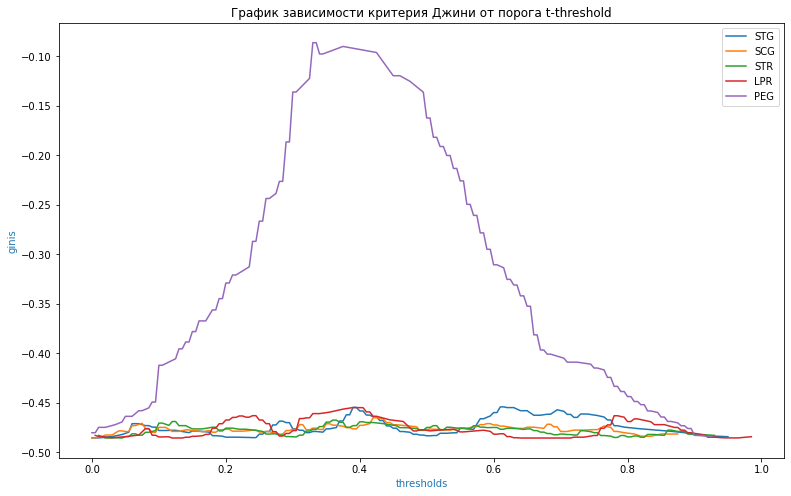

In [61]:
fig, ax = plt.subplots(figsize=(13,8))
plt.title("График зависимости критерия Джини от порога t-threshold")
ax.set_xlabel("thresholds", color="C0")
ax.set_ylabel("ginis", color="C0")
for name in list(df.columns[:-1]):
    thresholds1, variances1, threshold_best1, variance_best1 = find_best_split(
        df[name].to_numpy(), 
        y, 
        task="classification",
        feature_type="real"
    )
    ax.plot(thresholds1, variances1, label=name)
    ax.legend()

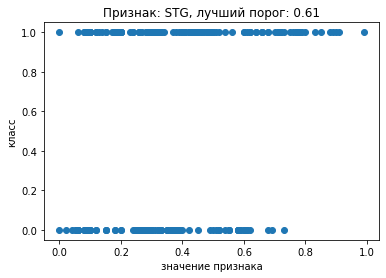

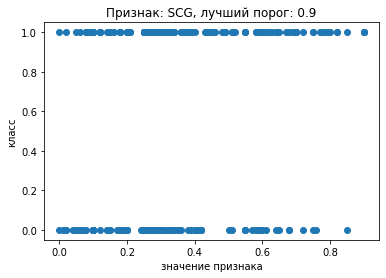

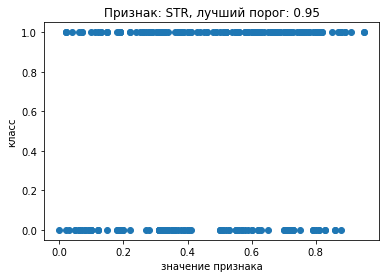

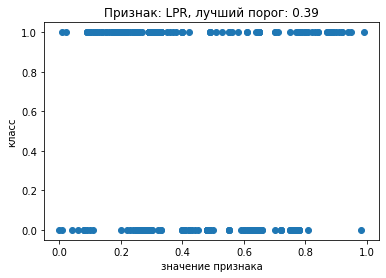

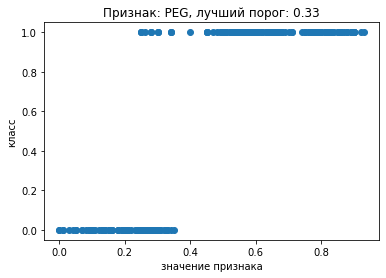

In [62]:
for name in list(df.columns[:-1]):
    thresholds1, variances1, threshold_best1, variance_best1 = find_best_split(
        df[name].to_numpy(), 
        y, 
        task="classification",
        feature_type="real"
    )
    plt.scatter(df[name], y)
    plt.title("Признак: {}, лучший порог: {}".format(name, threshold_best1))
    plt.xlabel("значение признака")
    plt.ylabel("класс")
    plt.show()

### Задание 2.4 (1 балл)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [63]:
print("По признаку PEG нужно производить деление выборки на 2 поддерева. С визуальной оценкой scatter-графиков этот выбор согласуется, т.к. именно для PEG "
     "по порогу 0.33 происходит наглядное разбиение выборки на два класса: всё, что слева, относится к классу 0, а справа - к классу 1."
      " Кривые для признаков, по которым деление почти невозможно, отличаются тем, что они пологие и порога, при котором очевиден максимум"
      " критерия Джини для них не наблюдается. Вид кривой же для хороших признаков будет иметь явный максимум в точке некоторого порога, " 
      "который и будет оптимален для деления выборки на два поддерева.")

По признаку PEG нужно производить деление выборки на 2 поддерева. С визуальной оценкой scatter-графиков этот выбор согласуется, т.к. именно для PEG по порогу 0.33 происходит наглядное разбиение выборки на два класса: всё, что слева, относится к классу 0, а справа - к классу 1. Кривые для признаков, по которым деление почти невозможно, отличаются тем, что они пологие и порога, при котором очевиден максимум критерия Джини для них не наблюдается. Вид кривой же для хороших признаков будет иметь явный максимум в точке некоторого порога, который и будет оптимален для деления выборки на два поддерева.


ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-

### Задание 2.5 (1 балл)

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [64]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
data = pd.read_csv("agaricus-lepiota.data")

In [65]:
data[-5:]

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l
8122,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,o,c,l


In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
le = LabelEncoder()
for name in list(data.columns):
    data[name] = le.fit_transform(data[name])

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(['p'],axis=1), data['p'], test_size=0.5)

In [68]:
lst =[]
i=0
for i in range(22):
    lst.append("categorical")
a = np.array(lst)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

22


In [76]:
model = DecisionTree(feature_types=a)

In [77]:
model.fit(X_train, y_train)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
y_pred = model.predict(X_test)

In [44]:
y_pred

array([None, None, None, ..., None, None, None], dtype=object)

In [45]:
accuracy_score(y_pred, y_test)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

## Часть 3: бэггинг, случайный лес

В данной части будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [81]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [82]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

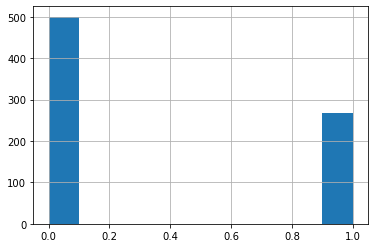

In [83]:
data['Outcome'].hist()
plt.show()

Разделите данные на признаки и целевую переменную. Разбейте датасет на тренировочную и тестовую части в отношении 70:30.

In [84]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Outcome'],axis=1), data['Outcome'], test_size=0.3)

### Задание 3.1 (1 балл)

Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [85]:
import random
random.seed(1234)
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
bc = BaggingClassifier(n_estimators=50)
bc.fit(X_train, y_train)
y_predict = bc.predict(X_test)

In [86]:
random.seed(1234)
print("accuracy:", "%.3f" % accuracy_score(y_predict, y_test))
print("precision:", "%.3f" % precision_score(y_predict, y_test))
print("recall:", "%.3f" % recall_score(y_predict, y_test))
print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))

accuracy: 0.749
precision: 0.582
recall: 0.565
auc_roc: 0.696


### Задание 3.2 (1 балл)

Теперь обучите Random Forest с таким же количеством деревьев. Оцените качество классификации по тем же метрикам. Какая из двух построенных моделей показала себя лучше?

In [87]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
random.seed(1234)
rfc = RandomForestClassifier(n_estimators=50)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

In [88]:
random.seed(1234)
print("accuracy:", "%.3f" % accuracy_score(y_predict, y_test))
print("precision:", "%.3f" % precision_score(y_predict, y_test))
print("recall:", "%.3f" % recall_score(y_predict, y_test))
print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))

accuracy: 0.753
precision: 0.582
recall: 0.574
auc_roc: 0.701


In [89]:
print("Результаты первой модели на 2-3% лучше, чем показатели второй.")

Результаты первой модели на 2-3% лучше, чем показатели второй.


### Задание 3.3 (1 балл)

Для случайного леса проанализируйте значение AUC-ROC на этих же данных в зависимости от изменения параметров (можете сделать обычный перебор с обучением/тестированием в цикле):
* `'n_estimators'` (можно перебрать около 10 значений из отрезка от 10 до 1500)
* `'min_samples_leaf'` (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости AUC-ROC от этих параметров. Используйте heat map для визуализации. Какие выводы вы можете сделать?

In [90]:
# ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
for i in range(10, 1400, 140):
    rfc = RandomForestClassifier(n_estimators=i, min_samples_leaf=8)
    rfc.fit(X_train, y_train)
    y_predict = rfc.predict(X_test)
    print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))

auc_roc: 0.682
auc_roc: 0.726
auc_roc: 0.726
auc_roc: 0.721
auc_roc: 0.721
auc_roc: 0.715
auc_roc: 0.721
auc_roc: 0.716
auc_roc: 0.721
auc_roc: 0.716


auc_roc: 0.710


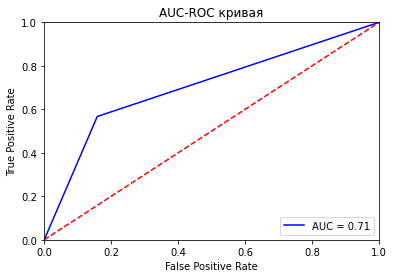

auc_roc: 0.721


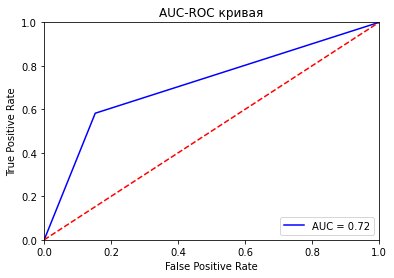

auc_roc: 0.721


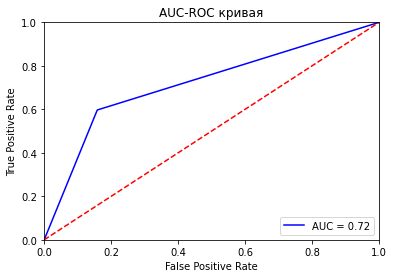

auc_roc: 0.716


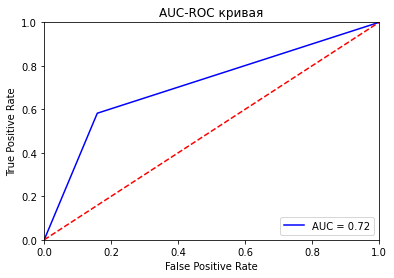

auc_roc: 0.721


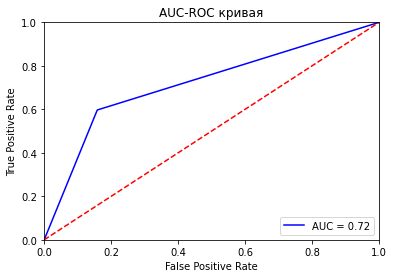

auc_roc: 0.721


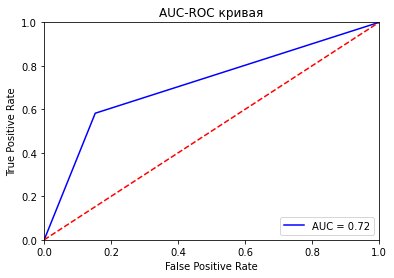

auc_roc: 0.716


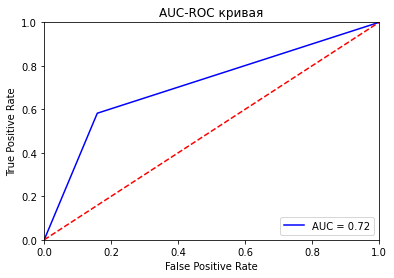

auc_roc: 0.721


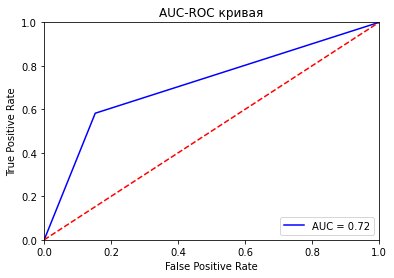

auc_roc: 0.721


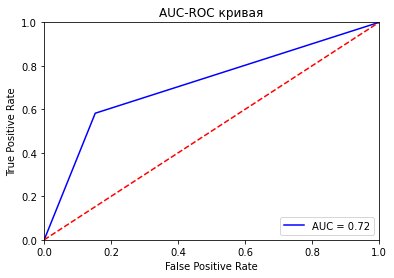

auc_roc: 0.716


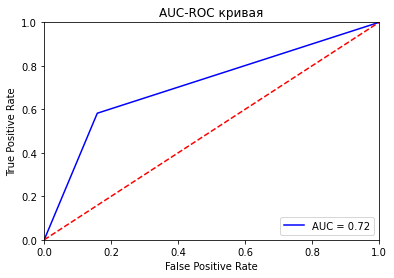

In [91]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

lst_index=[]
for i in range(10, 1400, 140):
    rfc = RandomForestClassifier(n_estimators=i, min_samples_leaf=8)
    rfc.fit(X_train, y_train)
    y_predict = rfc.predict(X_test)
    print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))
    lst.append(i)
    
    probs = rfc.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_predict)
    
    plt.title("AUC-ROC кривая")
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_predict, y_test))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [92]:
import matplotlib.pyplot as plt

In [94]:
random.seed(1234)
import seaborn as sns
dfh = pd.DataFrame()
lst_est=[]
lst_leaves=[]
for i in range(10, 1400, 140):
    lst_auc_roc=[]
    for j in range(1, 21): #по листьям
        rfc = RandomForestClassifier(n_estimators=i, min_samples_leaf=j)
        rfc.fit(X_train, y_train)
        y_predict = rfc.predict(X_test)
        #print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))
        lst_auc_roc.append(roc_auc_score(y_predict, y_test))
        lst_leaves.append(j)
    dfh[i] = lst_auc_roc #добавляю столбец значений, соотв. est такому-то для разных листов


<AxesSubplot:>

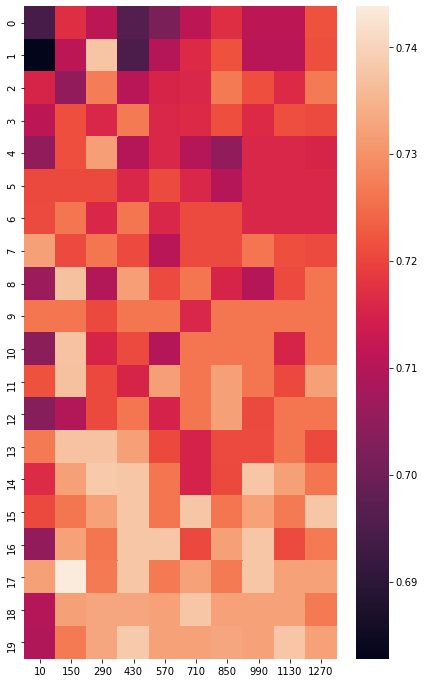

In [95]:
plt.figure(figsize=(7, 12))
sns.heatmap(dfh)

In [96]:
print(dfh[10][7], dfh[10][8])

0.7318713450292398 0.7065217391304348


In [105]:
print("При малом количестве деревьев результаты сильно зависят от минимального количества элементов в листе, причем произвольным образом (первый две полосы неоднородны в цвете."
     ". При этом для большого количества деревьев показатели сглаживаются и какое бы ни было количество листов (в выбранном диапозоне), отличия будут не более чем в ~2.5%. "
     "Также качество модели на большом количестве деревьев в среднем лучше, чем при малом их количестве, однако лучшие результаты для частных случаев находятся именно при выборе "
     "малого количества деревьев. Лучшая модель при 150 деревьях и 17 - мин. кол-во элементов в листе.")

При малом количестве деревьев результаты сильно зависят от минимального количества элементов в листе, причем произвольным образом (первый две полосы неоднородны в цвете.. При этом для большого количества деревьев показатели сглаживаются и какое бы ни было количество листов (в выбранном диапозоне), отличия будут не более чем в ~2.5%. Также качество модели на большом количестве деревьев в среднем лучше, чем при малом их количестве, однако лучшие результаты для частных случаев находятся именно при выборе малого количества деревьев. Лучшая модель при 150 деревьях и 17 - мин. кол-во элементов в листе.


### Задание 3.4 (1 балл)

Для лучшей модели случайного леса посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [109]:
random.seed(1234)
rfc = RandomForestClassifier(n_estimators=150, min_samples_leaf=16)
rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)
print("auc_roc:", "%.3f" % roc_auc_score(y_predict, y_test))
rfc.feature_importances_


auc_roc: 0.715


array([0.04615337, 0.40089572, 0.04088011, 0.03939448, 0.07026241,
       0.15769869, 0.07794763, 0.16676761])